**My Objectives**

<small>• To analyse the patterns and characteristics of known phishing attacks</small>
<br>
<small>• To develop a machine learning algorithm with comprehensive training dataset</small>
<br>
<small>• To evaluate the effectiveness of the developed machine learning model against other traditional rule-based methods for detecting phishing links</small>

In [1]:
# Python Tools for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Machine Learning Classification Algorithms
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.inspection import DecisionBoundaryDisplay

In [3]:
# Machine Learning Evaluation Metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [4]:
# Machine Learning Preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import make_pipeline
from tldextract import TLDExtract
import pickle

Import Raw Dataset

Label
good    392952
bad     114303
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 507255 entries, 0 to 549411
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     507255 non-null  object
 1   Label   507255 non-null  object
dtypes: object(2)
memory usage: 11.6+ MB


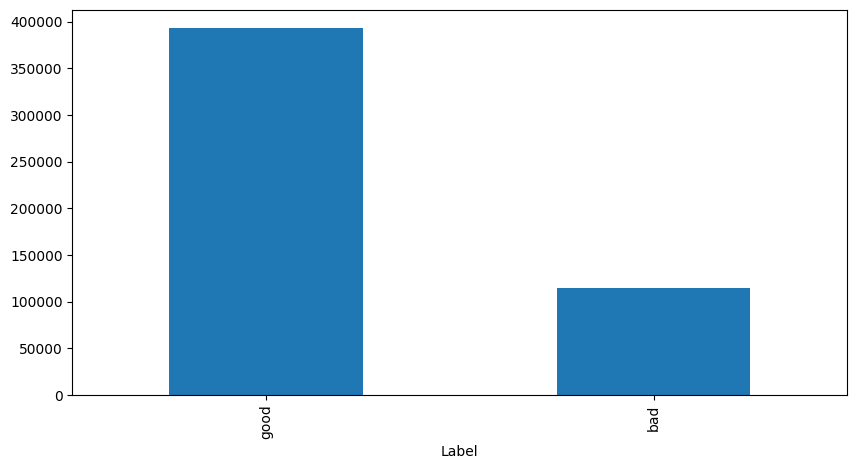

In [120]:
raw_dataset = pd.read_csv('datasets.csv')
raw_dataset = raw_dataset.dropna()
raw_dataset = raw_dataset.drop_duplicates()

raw_dataset['Label'].value_counts().plot(kind='bar', figsize=(10, 5))
print(raw_dataset['Label'].value_counts())
raw_dataset.head(5)
raw_dataset.info()

Suggested Features
- Keywords
- Domain Name
- URL Length
- No. of Subdomains

In [121]:
# Keywords
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
stemmer = SnowballStemmer("english")

sample = raw_dataset['URL'].sample(1).values[0]
print(f'Raw URL\t\t{sample}')

sample = tokenizer.tokenize(sample)
print(f'Tokenized URL\t{sample}')

sample = [stemmer.stem(word) for word in sample]
print(f'Stemmed URL\t{sample}')

sample = " ".join(sample)
print(f'Joined URL:\t{sample}')

Raw URL		imdb.com/title/tt0120601/
Tokenized URL	['imdb', 'com', 'title', 'tt']
Stemmed URL	['imdb', 'com', 'titl', 'tt']
Joined URL:	imdb com titl tt


In [122]:
# Domain name, Length & No. of Subdomains
extractor = TLDExtract()

sample = raw_dataset['URL'].sample(1).values[0]
print(f'Raw URL\t\t\t{sample}')

#join the domain and suffix
dom = extractor(sample).domain + '.' + extractor(sample).suffix
print(f'Domain name\t\t{dom}')

#count subdomains if existed
sub = [x for x in (extractor(sample).subdomain).split('.') if x]
print(f'Subdomain\t\t{", ".join(sub) if sub else None}')
print(f'Num of Subdomain\t{len(sub)}')

print(f'Length\t\t\t{len(sample)}')

Raw URL			plaxo.com/directory/V/2/3/


Domain name		plaxo.com
Subdomain		None
Num of Subdomain	0
Length			26


Generate new table with preprocessed data

In [123]:
raw_dataset['keywords'] = raw_dataset.URL.map(lambda t: ' '.join([stemmer.stem(word) for word in tokenizer.tokenize(t)]))
raw_dataset['domain'] = raw_dataset.URL.map(lambda t: extractor(t).domain + '.' + extractor(t).suffix)
raw_dataset['subnum'] = raw_dataset.URL.map(lambda t: len([x for x in (extractor(t).subdomain).split('.') if x]))
raw_dataset['length'] = raw_dataset.URL.map(lambda t: len(t))

In [117]:
raw_dataset.head(5)

,URL,Label,keywords,domain,subnum,length
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,nobel it ffb d dca cce f login skype com en cg...,nobell.it,0,225
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,www dghjdgf com paypal co uk cycgi bin webscrc...,dghjdgf.com,1,81
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,serviciosbi com paypal cgi bin get into herf s...,serviciosbys.com,0,177
3,mail.printakid.com/www.online.americanexpress....,bad,mail printakid com www onlin americanexpress c...,printakid.com,1,60
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,thewhiskeydreg com wp content theme widescreen...,thewhiskeydregs.com,0,116


In [124]:
raw_dataset.to_csv('preprocessed_datasets.csv', index=False)

_

_

_

Import Preprocessed Data

In [125]:
phish_data = pd.read_csv('preprocessed_datasets.csv')
phish_data = phish_data[phish_data['keywords'].notna()]

phish_data.isnull().sum()



URL         0
Label       0
keywords    0
domain      0
subnum      0
length      0
dtype: int64

In [6]:
classifiers = [
    #name,                              short,  classifier
    ['AdaBoost',                        'AB',   AdaBoostClassifier()],
    ['Decision Tree',                   'DT',   DecisionTreeClassifier(max_depth=5)],
    ['Random Forest',                   'RF',   RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)],
    ['Neural Network',                  'NN',   MLPClassifier(alpha=1, max_iter=1000)],
    ['Gaussion Process',                'GP',   GaussianProcessClassifier(1.0 * RBF(1.0))],
    ['K-Nearest Neighbors',             'KNN',  KNeighborsClassifier(3)],
    ['Logistic Regression',             'LR',   LogisticRegression(C=1e5)],
    ['Quadratic Discriminant Analysis', 'QDA',  QuadraticDiscriminantAnalysis()],
    ['Support Vector Machine',          'SVM',  SVC(kernel='linear', C=0.025)],
    ['Radial Basis Function SVM',       'RBF',  SVC(gamma=2, C=1)],
    ['Naive Bayes',                     'NB',   GaussianNB()],
    ['Bernoulli Naive Bayes',           'BNB',  BernoulliNB()],
    ['Complement Naive Bayes',          'CNB',  ComplementNB()],
    ['Multinomial Naive Bayes',         'MNB',  MultinomialNB()],
]

In [10]:
#Model functions
def clf(shortname, index=2):
    # Call using shortname to get the classifier object
    # index:
    # 0 is the classifier full name
    # 1 is the classifier short name
    # 2 is the classifier object

    for classifier in classifiers:
        if classifier[1] == shortname:
            return classifier[index]

In [11]:
#Visualisation functions
def disp_graph(name_list, result_list, type="bar"):
    plt.figure(figsize=(27, 9))
    if type == 'bar':
        plt.bar(name_list, result_list)
    elif type == 'line':
        plt.plot(name_list, result_list)

    for i, v in enumerate(result_list):
        plt.text(i, v, str(round(v, 2)), ha="center")

    plt.xticks(rotation=90)
    plt.show()
    


def plot_decision_boundary(X_train, y_train, X_test, y_test, classifiers, h=0.02):
    plt.figure(figsize=(27, 9))
    i = 1
    # iterate over classifiers
    for name, shortname, clf in classifiers:
        ax = plt.subplot(3, 6, i)
        clf.fit(X_train, y_train)
        # create a mesh to plot in
        x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
        y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolors='k')
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired, edgecolors='k')
        ax.set_title(f'{name}')

        i += 1

    plt.tight_layout()
    plt.show()

In [12]:
# Dataset functions
def get_sized_dataset(dataset, size, ratio):
    good_dataset = dataset[dataset['Label'] == 'good']
    bad_dataset = dataset[dataset['Label'] == 'bad']
    return pd.concat([good_dataset.sample(int(size * (1-ratio))), bad_dataset.sample(int(size * (ratio)))])


In [13]:
# Training and Testing fit functions
def get_count_vectorizer(dataset):
    cv = CountVectorizer()
    cv = cv.fit_transform(dataset)
    return cv

def get_reshape_data(dataset):
    return dataset.reshape(-1, 1)

In [14]:
#score functions
def get_score(x, y, selected_classifier):
    trainX, testX, trainY, testY = train_test_split(x, y)
    selected_classifier.fit(trainX, trainY)
    return selected_classifier.score(testX, testY)

---------------------------------------

Create a function to get the best models

In [8]:
def keywords_score(dataset, size, ratio, classifiers):
    result = []
    labels = []
    data = get_sized_dataset(dataset, size, ratio)
    x, y = data['keywords'], data['Label']

    for selected in classifiers:
        try:
            result.append(get_score(get_count_vectorizer(x), y, selected[2]))
            labels.append(selected[0])
        except:
            try:
                result.append(get_score(get_count_vectorizer(x).toarray(), y, selected[2]))
                labels.append(selected[0])

            except:
                result.append(0)
                labels.append(selected[0])

    for i in range(len(result)):
        score_list = []
        score_list.append(labels[i])
        score_list.append(round(result[i], 2))
        result[i] = score_list
    result.sort(key=lambda x: x[1], reverse=True)

    disp_graph([x[0] for x in result], [x[1] for x in result])

    for i in range(len(result)):
        print(result[i])


In [ ]:
#keywords_score(phish_data, 1000, 0.1, classifiers)

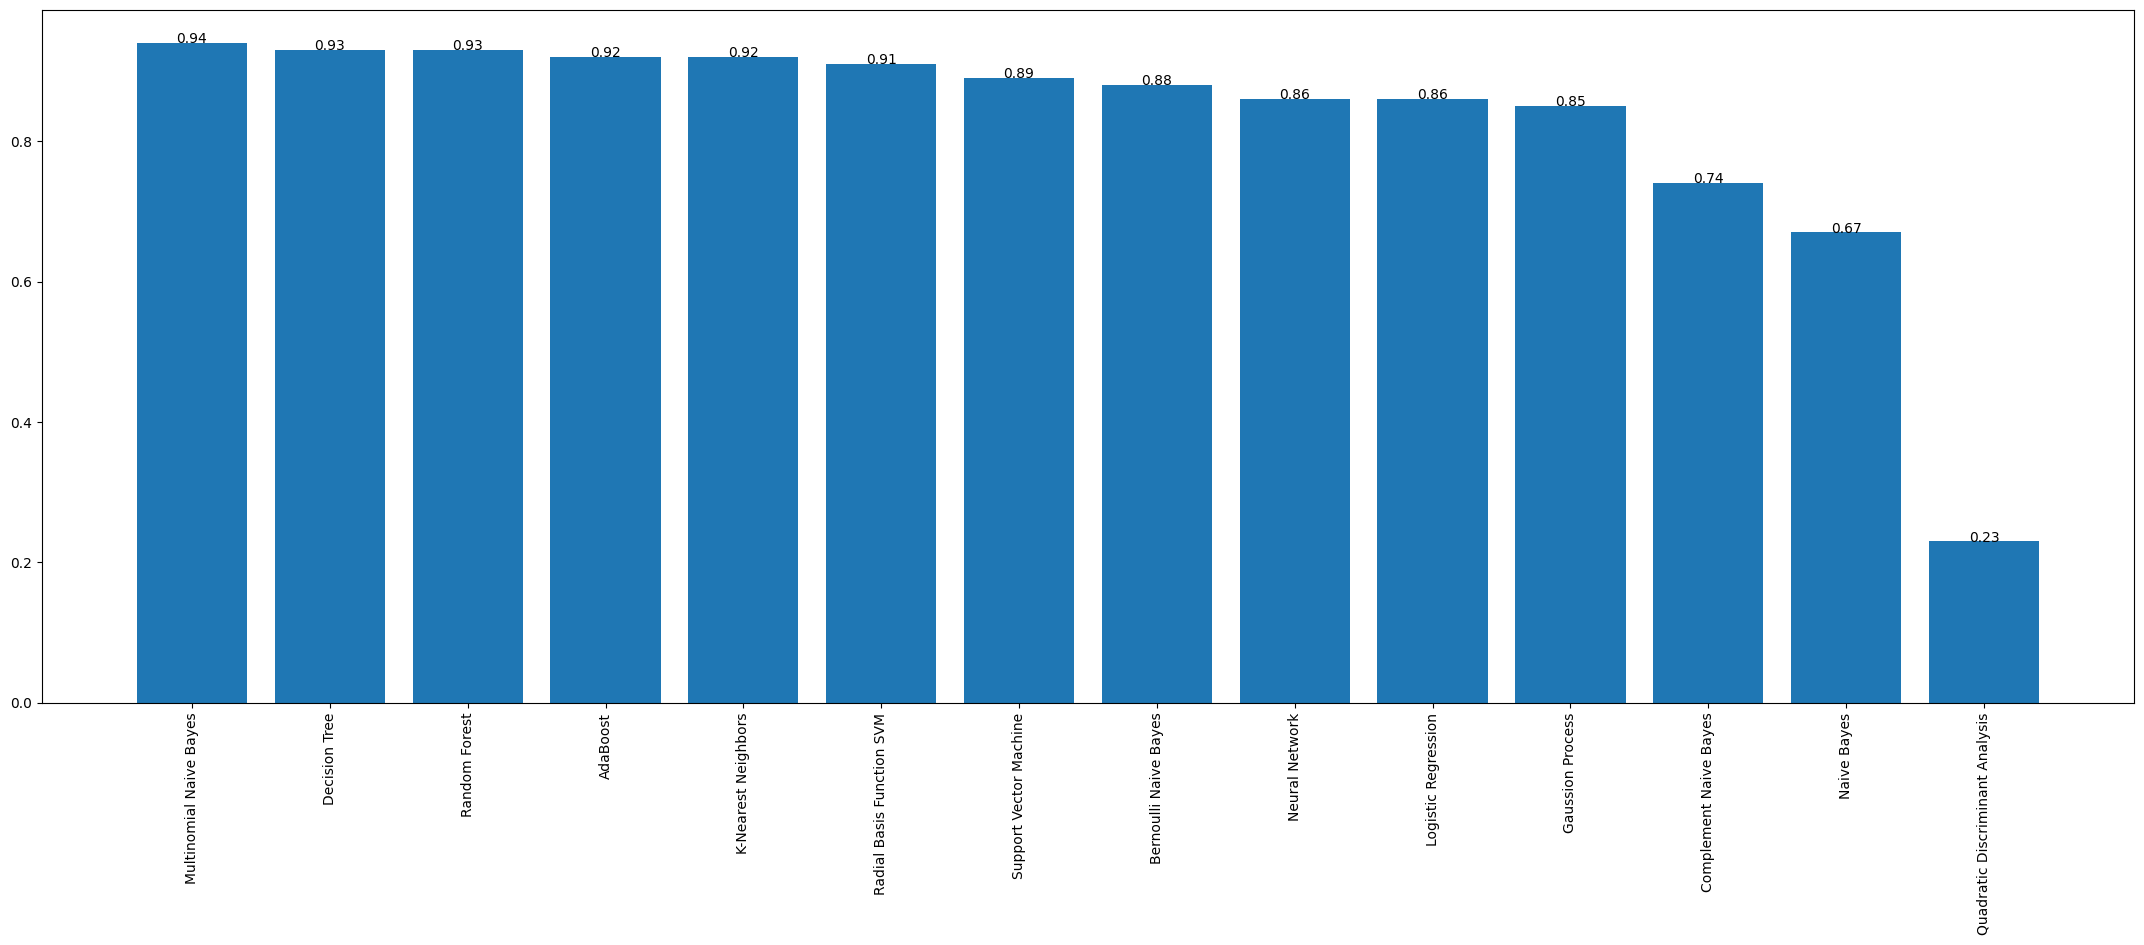
**Best in 500 (11 secs)**
- ['Multinomial Naive Bayes', 0.94]
- ['Decision Tree', 0.93]
- ['Random Forest', 0.93]
- ['AdaBoost', 0.92]
- ['K-Nearest Neighbors', 0.92]
- ['Radial Basis Function SVM', 0.91]
- ['Support Vector Machine', 0.89]
- ['Bernoulli Naive Bayes', 0.88]
- ['Neural Network', 0.86]
- ['Logistic Regression', 0.86]
- ['Gaussion Process', 0.85]
- ['Complement Naive Bayes', 0.74]
- ['Naive Bayes', 0.67]
- ['Quadratic Discriminant Analysis', 0.23]

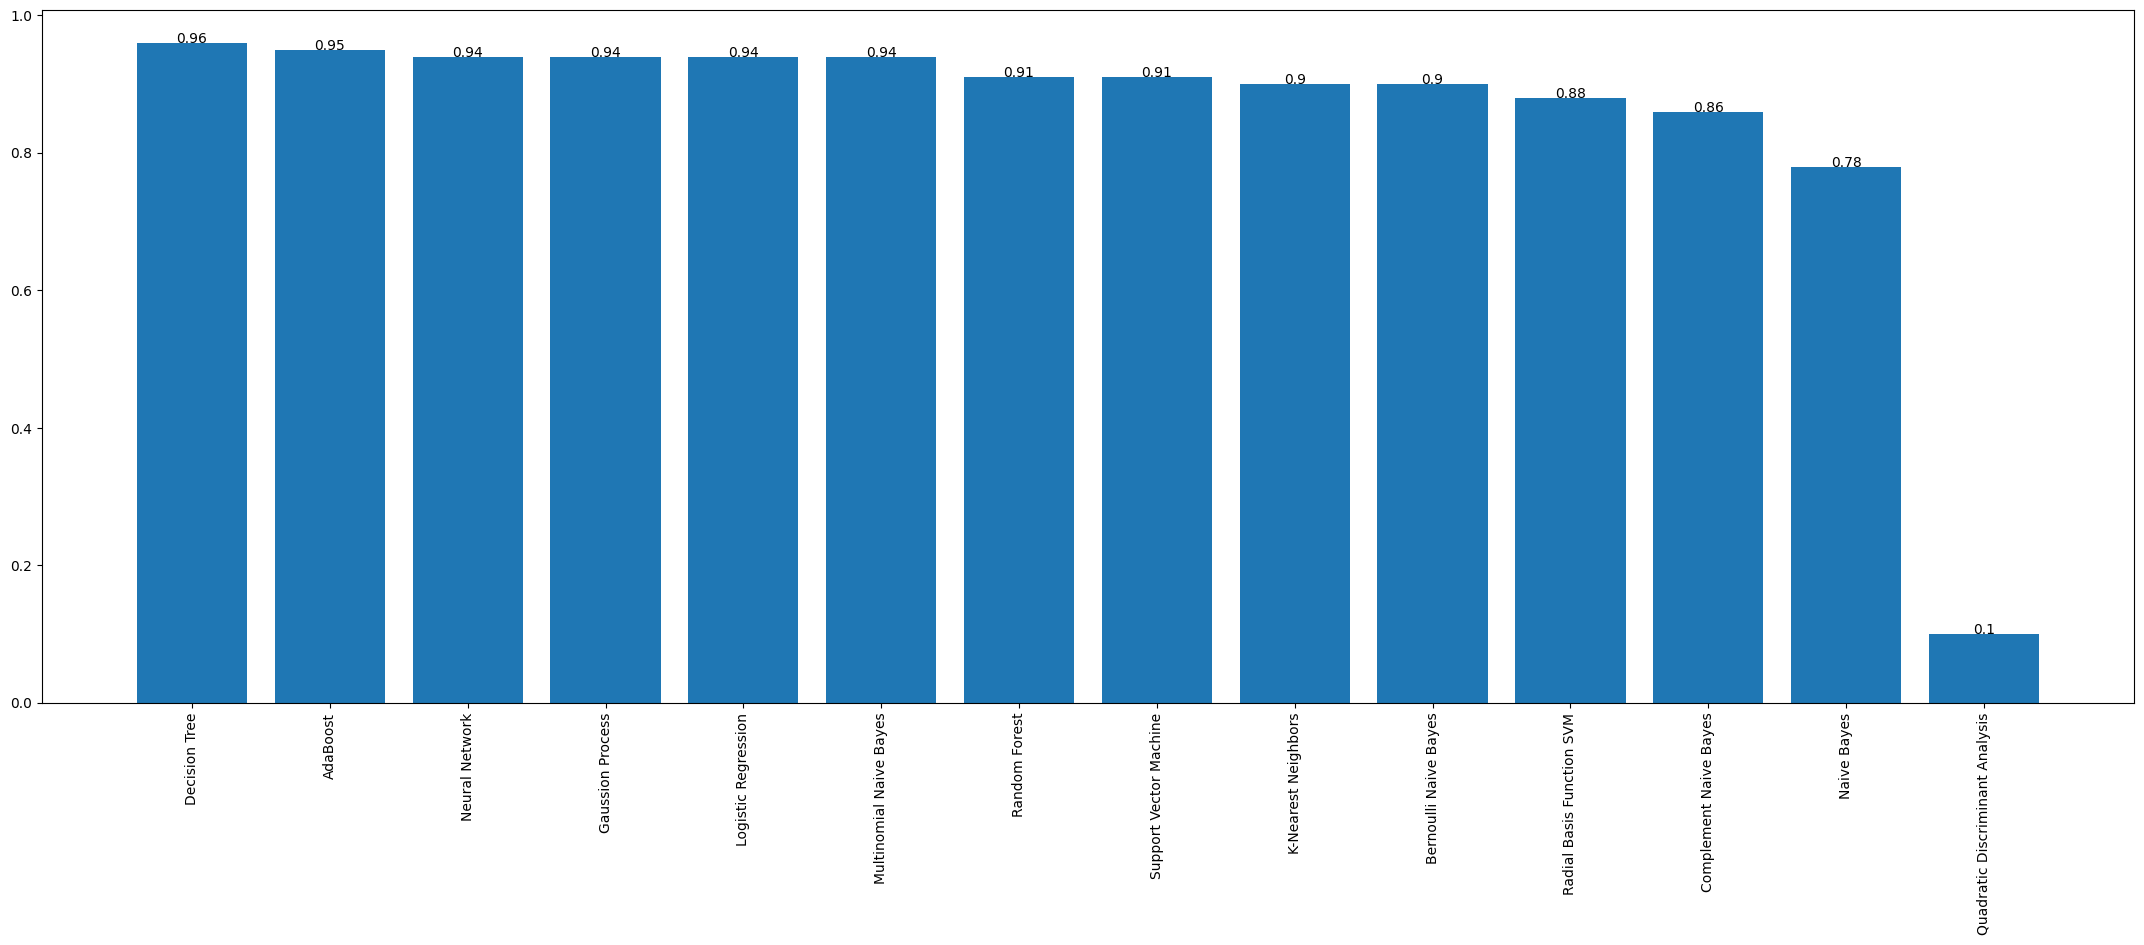
**Best in 1000 (1 min 30 secs)**
- ['Decision Tree', 0.96]
- ['AdaBoost', 0.95]
- ['Neural Network', 0.94]
- ['Gaussion Process', 0.94]
- ['Logistic Regression', 0.94]
- ['Multinomial Naive Bayes', 0.94]
- ['Random Forest', 0.91]
- ['Support Vector Machine', 0.91]
- ['K-Nearest Neighbors', 0.9]
- ['Bernoulli Naive Bayes', 0.9]
- ['Radial Basis Function SVM', 0.88]
- ['Complement Naive Bayes', 0.86]
- ['Naive Bayes', 0.78]
- ['Quadratic Discriminant Analysis', 0.1]

**Best in 5000**
- Failed (Execution time exceed 20 minutes)
- Need to filter out models that may cause slowness

**TOP 5 MODELS**
- AdaBoost
- Decision Tree
- Random Forest
- Logistic Regression
- Multinomial Naive Bayes

In [6]:
top_classifier = [
    ['AdaBoost',                        'AB',   AdaBoostClassifier()],
    ['Decision Tree',                   'DT',   DecisionTreeClassifier(max_depth=5)],
    ['Random Forest',                   'RF',   RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)],
    ['Logistic Regression',             'LR',   LogisticRegression(C=1e5)],
    ['MultinomialNB',                   'MNB',  MultinomialNB()],
]

In [ ]:
#keywords_score(phish_data, 10000, 0.1, top_classifier)

**Report**

100 (0.9 secs)
- ['Logistic Regression', 0.92]
- ['AdaBoost', 0.84]
- ['MultinomialNB', 0.84]
- ['Decision Tree', 0.8]
- ['Random Forest', 0.8]

500 (1.1 secs)
- ['Logistic Regression', 0.93]
- ['AdaBoost', 0.92]
- ['Decision Tree', 0.91]
- ['MultinomialNB', 0.91]
- ['Random Forest', 0.86]

1 000 (1.8 secs)
- ['Logistic Regression', 0.96]
- ['MultinomialNB', 0.94]
- ['Decision Tree', 0.92]
- ['AdaBoost', 0.91]
- ['Random Forest', 0.88]

5 000 (8.0 secs)
- ['Logistic Regression', 0.95]
- ['MultinomialNB', 0.95]
- ['AdaBoost', 0.94]
- ['Decision Tree', 0.92]
- ['Random Forest', 0.9]

10 000 (19.3 secs)
- ['Logistic Regression', 0.95]
- ['MultinomialNB', 0.95]
- ['AdaBoost', 0.94]
- ['Decision Tree', 0.92]
- ['Random Forest', 0.89]

Based on 5 different size datasets,
**Logistic Regression** was selected to be main models because it achieved top accuracy in all tests

Features
- Keywords
- domain name
- length
- no. of subdomain

In [93]:
phish_data.sample(10)

,URL,Label,keywords,domain,subnum,length
399201,myspace.com/events/View/8202834/Taylor-Swift/M...,good,myspac com event view taylor swift munich germ...,myspace.com,0,73
51787,merali0.tripod.com/landiseres/,good,merali tripod com landiser,tripod.com,1,30
478719,youtube.com/watch?v=yLAWtVQusTQ,good,youtub com watch v ylawtvqustq,youtube.com,0,31
277752,amazon.com/War-Don-Emmanuels-Nether-Parts/dp/0...,good,amazon com war don emmanuel nether part dp,amazon.com,0,55
233499,rapidog.com/elliott-smith-songbook-rapidshare....,good,rapidog com elliott smith songbook rapidshar html,rapidog.com,0,50
203321,joedoeatl.com/,good,joedoeatl com,joedoeatl.com,0,14
414652,planepictures.net/up/,good,planepictur net up,planepictures.net,0,21
190075,fr.linkedin.com/in/sebastienl,good,fr linkedin com in sebastienl,linkedin.com,1,29
464991,windowsmediacodecdownload.com/guides.htm,good,windowsmediacodecdownload com guid htm,windowsmediacodecdownload.com,0,40
103752,jmlettering.com/094mfiejr93ji/br/SANTANDER.VAN...,bad,jmletter com mfiejr ji br santand van gog clie...,jmlettering.com,0,205


In [126]:
print(phish_data['Label'].value_counts())

Label
good    392939
bad     113394
Name: count, dtype: int64


In [127]:
selected_classifier = LogisticRegression(C=1e5) #max_iter=1000, random_state=0
# x , y = phish_data['keywords'], phish_data['Label']

dataset_size = 500000
ratio = 0.22

data = get_sized_dataset(phish_data, dataset_size, ratio)
x, y = data['keywords'], data['Label']

trainX, testX, trainY, testY = train_test_split(x, y)

pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize, stop_words='english'), selected_classifier)
pipeline_ls.fit(trainX,trainY)
pipeline_ls.score(testX,testY) 

C:\Users\syami\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\syami\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.970552

Training Accuracy : 0.9949546666666667
Testing Accuracy : 0.970552

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.96      0.93     26015
        Good       0.99      0.97      0.98     98985

    accuracy                           0.97    125000
   macro avg       0.95      0.96      0.96    125000
weighted avg       0.97      0.97      0.97    125000


CONFUSION MATRIX


<Axes: >

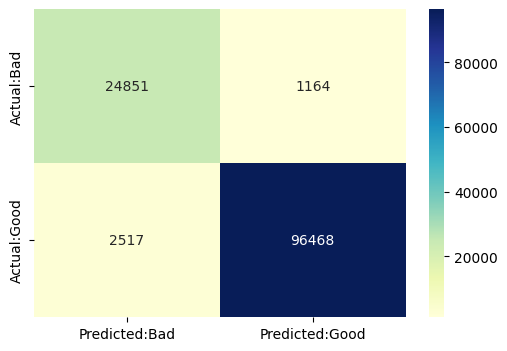

In [128]:
import seaborn as sns
print('Training Accuracy :',pipeline_ls.score(trainX,trainY))
print('Testing Accuracy :',pipeline_ls.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

Export the pipeline as pickle file (.pkl)

In [129]:
pickle.dump(pipeline_ls,open('classifier.pkl','wb'))

Testing Phase

In [130]:
loaded_model = pickle.load(open('classifier.pkl', 'rb'))
loaded_model

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)),
                ('logisticregression', LogisticRegression(C=100000.0))])

In [141]:
user_input = input("Insert URL: ")
result = loaded_model.predict([user_input])

print(result[0])

good


**Test Report**

#1 Safe URL Test:
- https://bobbyhadz.com/blog/lbfgs-failed-to-converge-stop-total-no-of-iterations-reached-limit#:~:text=The%20scikit-learn%20warning%20"ConvergenceWarning,for%20the%20solvers%20to%20converge. [Good]

- https://stackoverflow.com/questions/42754388/uncaught-in-promise-typeerror-failed-to-fetch-and-cors-error [Good]

- https://www.youtube.com/watch?v=3eytpBOkOFA&list=RDMuhkUzGAeHA&index=11 [Good]

#2 Danger URL Test:
- https://mlysiens-siteapps-mykasih-wrk.biz.id/Mykad9736x24 [Bad]
- https://is.gd/SumbanganAsasRahmahh [Bad]
- https://new.express.adobe.com/webpage/ijU54J6y8z2IP [Bad]
